# Chapter 2: A real example. Importing data and setting series

## Data Management


In this example we will show how we can import data from a csv and generate a model with several depositional series.

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np


../../gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


In this case instead loading a geo_data object directly, we will create one. The main atributes we need to pass are:
- Extent: X min, X max, Y min, Y max, Z min, Z max
- Resolution: X,Y,Z

Additionaly we can pass the address to csv files (GeoModeller3D format) with the data.

In [2]:
# Importing the data from csv files and settign extent and resolution
geo_data = gp.create_data([696000,747000,6863000,6930000,-20000, 200],[50, 50, 50],
                     path_o = os.pardir+"/input_data/tut_SandStone/SandStone_Foliations.csv",
                     path_i = os.pardir+"/input_data/tut_SandStone/SandStone_Points.csv")

You can visualize the points in 3D (work in progress)

Or a projection in 2D:

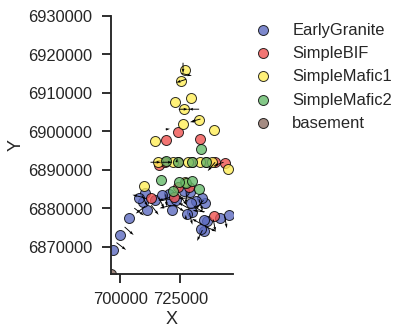

In [3]:
import matplotlib.pyplot as plt
gp.plotting.plot_data(geo_data, direction='z')


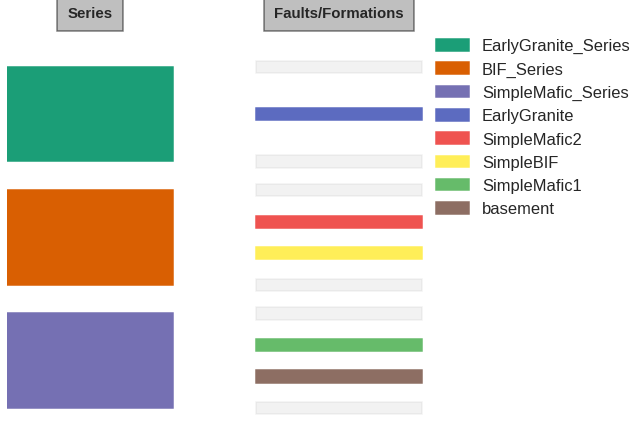

In [4]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                         "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"],
                      order_formations= ['EarlyGranite', 'SimpleMafic2',
                                         'SimpleBIF', 'SimpleMafic1'],
              verbose=1)

## Computing the model

Now as in the previous chapter we just need to create the interpolator object and compute the model.

In [5]:
interp_data = gp.InterpolatorData(geo_data, theano_optimizer='fast_run',
                                  compile_theano=False, verbose=[])

## Changing the points where we interpolate.

GemPy interpolation is continious in space and hence it is not bounded to a specific grid structure. The 3D points where we interpolate are stored in geo_data.grid.values. grid is an object that contains all the methods and properties related to grids (so far very ligth class). 

The easiest way to change the points to interpolate is by:

1) Creating a GridClass object with the new locations. There is a method to give custom locations

2) Set the new grid to the geo_data object

3) Update the interpolaor object (inter_data) with the new data without recompiling theano necessarilly.

In a last update this is implemented in the function `compute_model_at` (See Utilities tutorial for more information)

In [7]:
new_grid = gp.GridClass()
res =  100

# Create a new grid object with the new resolution
new_grid.set_regular_grid(geo_data.extent,[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

# Update the new grid
interp_data.update_interpolator(geo_data)

Since we did not create the theano function when we declared the `InterplatorData` object, GemPy will compile it the first time that `compute_model` is invoked.

In [8]:
lith_block, fault_block = gp.compute_model(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float32
Number of faults:  0


/home/miguel/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


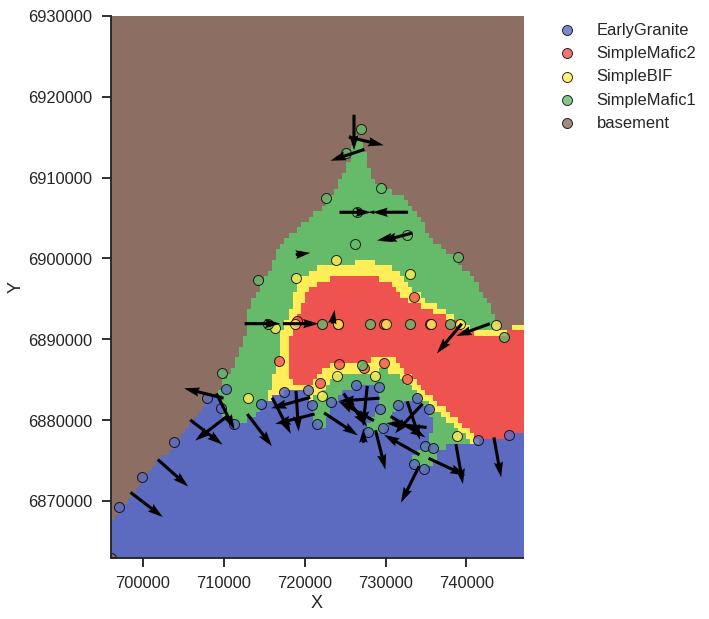

In [9]:
import matplotlib.pyplot as plt

gp.plotting.plot_section(geo_data, lith_block[0], -2, plot_data=True, direction='z')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

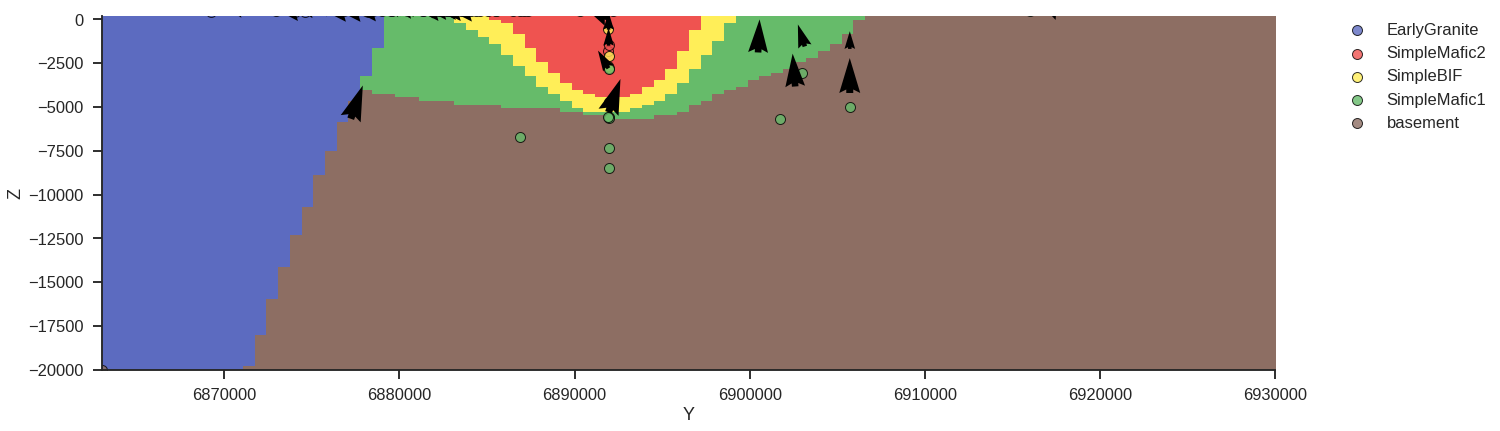

In [10]:
%matplotlib inline
gp.plotting.plot_section(geo_data, lith_block[0],50, plot_data=True, direction='x')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [11]:
ver, sim = gp.get_surfaces(interp_data, lith_block[1], None, original_scale=True)

gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)

closing vtk
